## Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine, i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is **to predict the number of remaining operational cycles before failure** in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.


In [20]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")


In [53]:
def load_data(index="FD004"):
    if type(index) == str:
        assert index in ["FD001", "FD002", "FD003", "FD004"]
    elif type(index) == int:
        assert index in [0, 1, 2, 3]
        index = f'FD00{index+1}'

    print("-----------------")
    print(f" Data Set: {index} ")
    print("-----------------")
    if index == "FD001":
        print("Train trjectories: 100")
        print("Test trajectories: 100")
        print("Conditions: ONE (Sea Level)")
        print("Fault Modes: ONE (HPC Degradation)\n")
    if index == "FD002":
        print("Train trjectories: 260")
        print("Test trajectories: 259")
        print("Conditions: SIX")
        print("Fault Modes: ONE (HPC Degradation)\n")
    if index == "FD003":
        print("Train trjectories: 100")
        print("Test trajectories: 100")
        print("Conditions: ONE (Sea Level)")
        print("Fault Modes: TWO (HPC Degradation, Fan Degradation)\n")
    if index == "FD004":
        print("Train trjectories: 248")
        print("Test trajectories: 249")
        print("Conditions: SIX")
        print("Fault Modes: TWO (HPC Degradation, Fan Degradation)\n")

    train_set = np.loadtxt(f"train_{index}.txt")
    test_set  = np.loadtxt(f"test_{index}.txt")

    col_names = ["unit_number", "time"]
    col_names += [f"operation{i}" for i in range(1, 4)]
    col_names += [f"sensor{i}" for i in range(1, 22)]
    train_set = pd.DataFrame(train_set, columns=col_names)
    test_set  = pd.DataFrame(test_set, columns=col_names)
    labels = np.loadtxt(f"RUL_{index}.txt")

    def set_dtype(df):
        return df.astype({"unit_number": np.int64, "time": np.int64})

    train_set = set_dtype(train_set)
    test_set  = set_dtype(test_set)

    return train_set, test_set, labels

In [60]:
# train_set, test_set, labels = load_data(index="FD004")
train_set, test_set, labels = load_data(index=3)

-----------------
 Data Set: FD004 
-----------------
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)



In [4]:
train_set

,unit_number,time,operation1,operation2,operation3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330.0,2212.0,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361.0,2324.0,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329.0,2212.0,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328.0,2212.0,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305.0,1915.0,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372.0,2319.0,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396.0,2388.0,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395.0,2388.0,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337.0,2223.0,100.00,15.26,9.0774


In [5]:
test_set.nunique()

unit_number      248
time             486
operation1       536
operation2       105
operation3         2
sensor1            6
sensor2         1480
sensor3        11326
sensor4        13257
sensor5            6
sensor6           61
sensor7         4173
sensor8          709
sensor9        18503
sensor10          18
sensor11         657
sensor12        3963
sensor13         307
sensor14       12152
sensor15        8724
sensor16           2
sensor17          49
sensor18           6
sensor19           2
sensor20         536
sensor21       16453
dtype: int64

In [6]:
labels.shape

(248,)

In [13]:
def run_to_failure_aux(df, lifetime, unit_number):

    assert lifetime <= df.shape[0]
    broken = 0 if lifetime < df.shape[0] else 1
    sample = pd.DataFrame(
        {'lifetime': lifetime, 'broken': broken, 'unit_number': unit_number}, index=[0])

    sensors = df.loc[:, df.columns.str.contains('sensor')]
    num_features = sensors.iloc[:lifetime].agg(['min', 'max', 'mean', 'std'])
    num_features = num_features.unstack().reset_index()
    num_features['feature'] = num_features.level_0.str.cat(
        num_features.level_1, sep='_')
    num_features = num_features.pivot_table(columns='feature', values=0)

    return pd.concat([sample, num_features], axis=1)


In [14]:
def censoring_augmentation(raw_data, n_samples=10, seed=123):

    np.random.seed(seed)
    datasets = [g for _, g in raw_data.groupby('unit_number')]
    timeseries = raw_data.groupby('unit_number').size()
    samples = []
    pbar = tqdm.tqdm(total=n_samples, desc='augmentation')

    while len(samples) < n_samples:
        # draw a machine
        unit_number = np.random.randint(timeseries.shape[0])
        censor_timing = np.random.randint(timeseries.iloc[unit_number])
        sample = run_to_failure_aux(datasets[unit_number], censor_timing, unit_number)
        samples.append(sample)
        pbar.update(1)

    return pd.concat(samples).reset_index(drop=True).fillna(0)

In [45]:
def generate_run_to_failure(df, health_censor_aug=0, seed=123):

    samples = []
    for unit_id, timeseries in tqdm.tqdm(df.groupby('unit_number'), desc='RUL'):
        samples.append(run_to_failure_aux(timeseries, timeseries.shape[0], unit_id))

    samples = pd.concat(samples)

    if health_censor_aug > 0:
        aug_samples = censoring_augmentation(
            df, n_samples=health_censor_aug, seed=seed)
        return pd.concat([samples, aug_samples]).reset_index(drop=True)
    else:
        return samples.reset_index(drop=True)

In [46]:
dataset = generate_run_to_failure(train_set,
    health_censor_aug=train_set.unit_number.nunique() * 3)

dataset.sample(10).sort_index()

RUL: 100%|██████████| 249/249 [00:04<00:00, 53.91it/s]


249


augmentation: 100%|██████████| 747/747 [00:14<00:00, 51.03it/s]


,lifetime,broken,unit_number,sensor10_max,sensor10_mean,sensor10_min,sensor10_std,sensor11_max,sensor11_mean,sensor11_min,...,sensor7_min,sensor7_std,sensor8_max,sensor8_mean,sensor8_min,sensor8_std,sensor9_max,sensor9_mean,sensor9_min,sensor9_std
18,210,1,19,1.30,1.094667,0.94,0.123312,48.29,43.251429,36.67,...,137.21,143.104351,2388.26,2236.023381,1915.06,133.760475,9051.77,8511.442905,7995.72,317.918153
110,297,1,111,1.31,1.101785,0.94,0.129875,48.03,42.750808,36.23,...,138.16,150.369226,2388.48,2226.370034,1915.26,147.589550,9113.30,8523.673939,7998.72,341.803374
219,202,1,220,1.30,1.089851,0.94,0.126788,48.23,42.873168,36.53,...,137.96,149.555538,2388.22,2226.275891,1915.24,147.334706,9119.70,8520.675842,8000.59,343.428212
247,184,1,248,1.30,1.096848,0.94,0.127356,48.31,43.222228,36.62,...,136.75,148.291098,2388.28,2234.908043,1915.10,137.172249,9063.43,8518.375815,8001.29,329.959637
406,173,0,232,1.30,1.093931,0.94,0.128414,47.58,42.784335,36.49,...,137.69,148.488114,2388.10,2225.741734,1915.32,145.387305,9072.98,8516.108728,8006.90,337.374457
729,49,0,17,1.30,1.085306,0.93,0.126904,47.23,42.414694,36.25,...,137.65,143.295412,2388.00,2220.088980,1915.28,158.106404,9059.22,8506.316327,8000.07,347.468470
760,162,0,109,1.30,1.089136,0.94,0.129473,47.75,42.551173,36.45,...,137.95,145.975746,2388.16,2214.446605,1915.39,152.990723,9080.87,8498.473457,8008.27,340.997640
799,87,0,57,1.30,1.092529,0.94,0.125097,47.26,42.555747,36.30,...,137.23,140.539493,2388.02,2230.337241,1915.28,135.123296,9056.86,8499.738046,7999.23,317.003934
891,216,0,184,1.32,1.109259,0.94,0.131462,48.15,42.983519,36.26,...,138.28,151.517625,2388.52,2233.411204,1915.32,147.172362,9117.27,8550.476991,8000.18,347.682665
944,56,0,144,1.30,1.078929,0.94,0.120131,47.31,42.373750,36.41,...,138.42,141.642535,2388.04,2219.422500,1915.44,147.686728,9073.32,8498.380000,8011.11,329.908161


<AxesSubplot:>

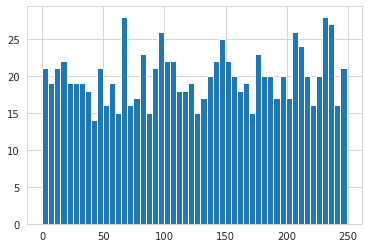

In [47]:
dataset.unit_number.hist(bins=50)

<AxesSubplot:>

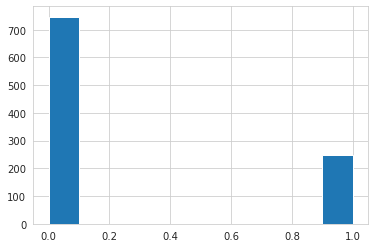

In [48]:
dataset.broken.hist()

In [79]:
def leave_one_out(target='run-to-failure',
                  health_censor_aug=1000, seed=123,
                  input_fn=None, output_fn=None):

    if input_fn is not None:
        subsets = pd.read_csv(input_fn)

    else:
        subsets = []
        for index in range(4):
            raw_data = load_data(index=index)[0]
            raw_data = raw_data.assign(machine_id=index)

            if target == 'run-to-failure':
                subset = generate_run_to_failure(raw_data, health_censor_aug, seed)
                subset = subset.assign(fold=index)
                subsets.append(subset)

            elif target == 'time-to-failure':
                raise NotImplementedError

            else:
                raise ValueError

        subsets = pd.concat(subsets).reset_index(drop=True)

    if output_fn is not None:
        subsets.to_csv(output_fn, index=False)

    # List of tuples: (train_data, test_data)
    train_test_sets = [(
        subsets[subsets.fold != i].reset_index(drop=True),
        subsets[subsets.fold == i].reset_index(drop=True)) for i in range(4)]

    return train_test_sets

In [80]:
dataset = leave_one_out()

-----------------
 Data Set: FD001 
-----------------
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)



RUL: 100%|██████████| 100/100 [00:01<00:00, 53.67it/s]


100


augmentation: 100%|██████████| 1000/1000 [00:19<00:00, 50.68it/s]


-----------------
 Data Set: FD002 
-----------------
Train trjectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)



RUL: 100%|██████████| 260/260 [00:04<00:00, 53.43it/s]


260


augmentation: 100%|██████████| 1000/1000 [00:19<00:00, 50.39it/s]


-----------------
 Data Set: FD003 
-----------------
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)



RUL: 100%|██████████| 100/100 [00:01<00:00, 53.50it/s]


100


augmentation: 100%|██████████| 1000/1000 [00:19<00:00, 50.29it/s]


-----------------
 Data Set: FD004 
-----------------
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)



RUL: 100%|██████████| 249/249 [00:04<00:00, 53.47it/s]


249


augmentation: 100%|██████████| 1000/1000 [00:20<00:00, 49.90it/s]


In [84]:
train_set, test_set = dataset[0]
train_set

,lifetime,broken,unit_number,sensor10_max,sensor10_mean,sensor10_min,sensor10_std,sensor11_max,sensor11_mean,sensor11_min,...,sensor7_std,sensor8_max,sensor8_mean,sensor8_min,sensor8_std,sensor9_max,sensor9_mean,sensor9_min,sensor9_std,fold
0,149,1,1,1.3,1.090067,0.94,0.127218,48.09,43.025034,36.57,...,150.310502,2388.31,2225.951141,1915.02,145.058326,9051.13,8494.444698,7993.23,337.597669,1
1,269,1,2,1.3,1.088513,0.94,0.125231,48.20,42.925242,36.51,...,143.960824,2388.22,2224.959740,1915.41,147.041472,9092.23,8522.055948,8005.94,334.778995,1
2,206,1,3,1.3,1.088010,0.94,0.121263,48.23,42.867864,36.33,...,137.527376,2388.27,2229.822379,1915.32,138.861063,9070.12,8511.947379,8007.77,318.426341,1
3,235,1,4,1.3,1.095064,0.94,0.126890,48.25,43.090553,36.51,...,148.840524,2388.17,2233.216596,1915.32,141.616056,9150.14,8543.702723,8004.46,338.356730,1
4,154,1,5,1.3,1.089026,0.94,0.127293,47.90,42.642273,36.42,...,138.124750,2388.14,2216.743961,1915.37,151.304381,9102.41,8511.127013,8006.91,333.957534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,218,0,228,1.3,1.095367,0.94,0.128088,47.74,42.887890,36.43,...,150.359194,2388.12,2231.079083,1915.27,148.087595,9073.12,8530.657844,8004.85,343.000308,3
3605,10,0,220,1.3,1.079000,0.94,0.113083,47.18,42.624000,36.67,...,140.267148,2388.05,2235.228000,1915.41,129.226524,9056.03,8498.448000,8014.59,309.429079,3
3606,59,0,65,1.3,1.076949,0.94,0.127025,47.15,42.017288,36.26,...,146.551874,2387.99,2204.205593,1915.23,159.788361,9052.51,8458.728644,7996.12,346.873360,3
3607,56,0,203,1.3,1.110714,0.94,0.129430,47.46,43.120000,36.44,...,147.589189,2388.04,2243.896964,1915.47,131.021681,9069.62,8556.057143,8012.46,322.942224,3


<AxesSubplot:>

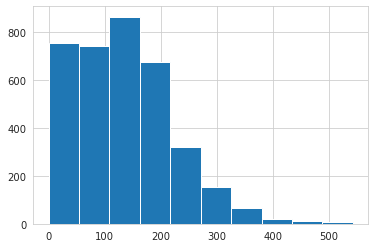

In [85]:
train_set.lifetime.hist()